In [1]:
!pip -q install -U transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 110.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 22.3 MB/s eta 0:00:00


In [2]:
import os, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if torch.cuda.is_available() else torch.float32

MODEL_NAME  = "gpt2-large"
REWARD_NAME = "lvwerra/distilbert-imdb"

# PPO hyperparams (start small with gpt2-large)
SEED = 42
MAX_SAMPLES     = 400        # number of prompts used for training (increase later)
BATCH_SIZE      = 2          # gpt2-large -> keep small on Kaggle
EPOCHS          = 1
PPO_EPOCHS      = 2        # PPO updates per rollout batch
MAX_NEW_TOKENS  = 48
PROMPT_MAX_LEN  = 128         # truncate prompt tokens (keeps compute bounded)

LR = 1e-5
CLIP_EPS    = 0.2
KL_COEF     = 0.2
VALUE_COEF  = 0.1
ENTROPY_COEF= 0.0            # keep 0 for speed; set small like 0.001 if needed

EVAL_EVERY_STEPS = 25
OUTPUT_DIR = "/kaggle/working/ppo_gpt2large_imdb"

# ---- SFT config
SFT_DIR = "/kaggle/working/sft_gpt2large_imdb_pos"
SFT_MAX_SAMPLES = 20000      # monte/descend selon GPU
SFT_MAX_LEN = 256
SFT_BATCH_SIZE = 1           # gpt2-large => 1
SFT_GRAD_ACCUM = 8
SFT_EPOCHS = 1
SFT_LR = 2e-5


os.makedirs(OUTPUT_DIR, exist_ok=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print("Device:", DEVICE, "| dtype:", DTYPE)

2026-01-07 08:48:11.295963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767775691.454654      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767775691.502463      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767775691.874736      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767775691.874786      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767775691.874789      55 computation_placer.cc:177] computation placer alr

Device: cuda | dtype: torch.float16


# Data 

In [3]:
from datasets import load_dataset

ds = load_dataset("imdb")

# On ne garde que les reviews positives (label=1)
pos_train = ds["train"].filter(lambda x: x["label"] == 1)

# Option: subset pour aller vite
pos_train = pos_train.select(range(min(SFT_MAX_SAMPLES, len(pos_train))))

def make_prompt_and_full(text, n_words=8):
    words = str(text).split()
    prompt = " ".join(words[:n_words])
    full = str(text)
    return prompt, full

# On crée prompt + full_text (on va apprendre surtout la partie après le prompt)
def build_sft_example(ex):
    prompt, full = make_prompt_and_full(ex["text"], n_words=8)
    return {"prompt": prompt, "full_text": full}

pos_train = pos_train.map(build_sft_example, remove_columns=pos_train.column_names)
pos_train[0]


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

{'prompt': 'Zentropa has much in common with The Third',
 'full_text': 'Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn\'t really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I\'d have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.'}

# Finetune SFT

In [4]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_sft(ex):
    prompt = ex["prompt"]
    full_text = ex["full_text"]

    # tokenize full sequence
    full = tokenizer(
        full_text,
        truncation=True,
        max_length=SFT_MAX_LEN,
        padding=False
    )

    # tokenize prompt to know how many tokens to mask
    pr = tokenizer(
        prompt,
        truncation=True,
        max_length=SFT_MAX_LEN,
        padding=False
    )
    prompt_len = len(pr["input_ids"])

    labels = full["input_ids"].copy()
    # mask prompt tokens
    for i in range(min(prompt_len, len(labels))):
        labels[i] = -100

    full["labels"] = labels
    return full

tok_sft = pos_train.map(tokenize_sft, remove_columns=pos_train.column_names)
tok_sft.set_format(type="torch")
tok_sft[0]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

{'input_ids': tensor([   57,   298,  1773,    64,   468,   881,   287,  2219,   351,   383,
         10467,  1869,    11,  1194,   645,   343,    12,  2339,  2646,   900,
          1871,   262, 29632,   286, 44060,  2031,    13,  4525,   309, 15972,
            11,   612,   318,   881, 47602,  4676,   670,    13,  1318,   318,
           281, 10218,  1605,   508,  3011, 17991,  2950,   351,   257,  2415,
           339,  1595,   470,  1107,  1833,    11,   290,  3025, 24354,   774,
           318,   477,   262,   517,  8871,   287,  6273,   351,   262, 30962,
         29847,  1671,  1220,  6927,  1671, 11037,  1537,   314,  1549,   423,
           284,   910,   326,   383, 10467,  1869,   468,   257,   517,   880,
            12, 39160, 22992,    13,  1168,   298,  1773,    64,   318,   257,
          1643,   595,    73, 20909,   287,   428,  2461,    13,  8673,   428,
           318, 21391,    25,   340,   318,  5545,   355,   257,  4320,    14,
          3847, 11449,    11,   290,  1

In [5]:
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import os

def freeze_for_sft(model):
    # Freeze tout
    for p in model.parameters():
        p.requires_grad = False
    # Unfreeze dernier block + ln_f + lm_head
    for p in model.transformer.h[-1].parameters():
        p.requires_grad = True
    for p in model.transformer.ln_f.parameters():
        p.requires_grad = True
    for p in model.lm_head.parameters():
        p.requires_grad = True

model_sft = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)

# stabilité / mémoire
model_sft.gradient_checkpointing_enable()
model_sft.config.use_cache = False

freeze_for_sft(model_sft)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

args = TrainingArguments(
    output_dir=SFT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=SFT_EPOCHS,
    per_device_train_batch_size=SFT_BATCH_SIZE,
    gradient_accumulation_steps=SFT_GRAD_ACCUM,
    learning_rate=SFT_LR,
    fp16=(DEVICE=="cuda"),
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

trainer = Trainer(
    model=model_sft,
    args=args,
    train_dataset=tok_sft,
    data_collator=data_collator,
)

trainer.train()
trainer.save_model(SFT_DIR)
tokenizer.save_pretrained(SFT_DIR)

print("SFT saved to:", SFT_DIR)


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,3.339700
100,3.283500
150,3.290600
200,3.305000
250,3.290900
300,3.309200
350,3.318600
400,3.301000
450,3.273400
500,3.255100


SFT saved to: /kaggle/working/sft_gpt2large_imdb_pos


In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(SFT_DIR)
tokenizer.pad_token = tokenizer.eos_token

# Policy démarre à partir du SFT
policy_lm = AutoModelForCausalLM.from_pretrained(SFT_DIR).to(DEVICE)

# Ref = le SFT (gelé)
ref_lm = AutoModelForCausalLM.from_pretrained(SFT_DIR).to(DEVICE)
ref_lm.eval()
for p in ref_lm.parameters():
    p.requires_grad = False

print("Loaded PPO base from SFT:", SFT_DIR)


Loaded PPO base from SFT: /kaggle/working/sft_gpt2large_imdb_pos


# Reward

In [7]:
reward_pipe = pipeline(
    "sentiment-analysis",
    model=REWARD_NAME,
    device=0 if DEVICE == "cuda" else -1
)

# robust conversion to P(POSITIVE)
def pos_prob(output):
    lab = output["label"].upper()
    s = float(output["score"])
    # common label patterns:
    # - POSITIVE / NEGATIVE
    # - LABEL_1 / LABEL_0
    if ("POS" in lab) or (lab.endswith("1")):
        return s
    return 1.0 - s

def reward_from_text(completion_text: str) -> float:
    # Reward in [-1, 1]
    out = reward_pipe(completion_text)[0]
    ppos = pos_prob(out)
    return 2.0 * ppos - 1.0

# quick sanity check
print(reward_pipe("This movie was amazing!")[0])
print(reward_pipe("This movie was awful.")[0])

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


{'label': 'POSITIVE', 'score': 0.9938137531280518}
{'label': 'NEGATIVE', 'score': 0.9966579675674438}


# Utils

In [8]:
def right_pad_1d(seqs, pad_id, device):
    """
    seqs: list of 1D LongTensor (variable length)
    returns input_ids [B,T], attention_mask [B,T], seq_lens [B]
    """
    lens = torch.tensor([s.numel() for s in seqs], dtype=torch.long)
    T = int(lens.max().item())
    B = len(seqs)

    input_ids = torch.full((B, T), pad_id, dtype=torch.long)
    attn = torch.zeros((B, T), dtype=torch.long)

    for i, s in enumerate(seqs):
        L = s.numel()
        input_ids[i, :L] = s
        attn[i, :L] = 1

    return input_ids.to(device), attn.to(device), lens.to(device)

def logprobs_from_logits(logits, labels):
    """
    logits [B,T,V], labels [B,T]
    -> per-token log p(label) [B,T]
    IMPORTANT: no .float() here (keeps dtype consistent for fp16 backward)
    """
    logp = F.log_softmax(logits, dim=-1)
    return torch.gather(logp, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)


def build_completion_mask(attn_mask, prompt_lens, seq_lens):
    """
    We work in SHIFT space: predicting token t+1 => positions [0..T-2] aligned with labels=input_ids[:,1:].
    Completion token indices in original sequence: [prompt_len .. seq_len-1]
    In SHIFT positions, completion starts at (prompt_len-1).
    """
    B, T = attn_mask.shape
    shift_T = T - 1
    mask = torch.zeros((B, shift_T), dtype=torch.float32, device=attn_mask.device)

    for i in range(B):
        pl = int(prompt_lens[i].item())
        sl = int(seq_lens[i].item())
        start = max(pl - 1, 0)
        end = max(sl - 1, 0)
        if end > start:
            mask[i, start:end] = 1.0

    # remove padded shift positions
    shift_attn = attn_mask[:, 1:].float()
    return mask * shift_attn

def masked_sum(x, m, eps=1e-8):
    return (x * m).sum(dim=-1)

def masked_mean(x, m, eps=1e-8):
    denom = m.sum(dim=-1).clamp_min(eps)
    return (x * m).sum(dim=-1) / denom

def ppo_clipped_loss(old_logp_seq, new_logp_seq, adv, clip_eps=0.2):
    log_ratio = torch.clamp(new_logp_seq - old_logp_seq, -10.0, 10.0)
    ratio = torch.exp(log_ratio)
    clipped = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
    return -torch.min(ratio * adv, clipped * adv).mean()

def approx_kl_token_mean(logp_new_tok, logp_ref_tok, comp_mask):
    return masked_mean(logp_new_tok - logp_ref_tok, comp_mask).mean

def true_kl_mean_completion(policy_model, ref_model, input_ids, attention_mask, comp_mask):
    """
    TRUE KL(pi||ref) averaged over completion tokens.
    input_ids: [B,T]
    attention_mask: [B,T]
    comp_mask: [B,T-1] (shift-space mask selecting completion tokens)
    """
    pol = policy_model(input_ids=input_ids, attention_mask=attention_mask).logits[:, :-1, :]
    ref = ref_model(input_ids=input_ids, attention_mask=attention_mask).logits[:, :-1, :]

    # do in fp32 for numerical stability (no grads here)
    pol = pol.float()
    ref = ref.float()

    p_logp = F.log_softmax(pol, dim=-1)
    q_logp = F.log_softmax(ref, dim=-1)
    p = p_logp.exp()

    kl_tok = (p * (p_logp - q_logp)).sum(dim=-1)  # [B,T-1]
    kl_mean = (kl_tok * comp_mask).sum() / (comp_mask.sum() + 1e-8)
    return float(kl_mean.item())

In [9]:
# ==========================================
# Cell 6 — Value head + ActorCritic wrapper (dtype-safe) + optimizer setup
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class ValueHead(nn.Module):
    def __init__(self, hidden_size, dtype):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        ).to(dtype)

    def forward(self, x):  # x: [B,H]
        # Make sure activations match the head's weights dtype
        x = x.to(self.net[0].weight.dtype)
        return self.net(x).squeeze(-1)


class ActorCritic(nn.Module):
    def __init__(self, lm):
        super().__init__()
        self.lm = lm
        lm_dtype = next(self.lm.parameters()).dtype
        self.v_head = ValueHead(self.lm.config.n_embd, dtype=lm_dtype)

    def forward(self, input_ids, attention_mask):
        out = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        logits = out.logits                     # [B,T,V]
        h_last = out.hidden_states[-1][:, -1, :] # [B,H] (right padding assumed)
        values = self.v_head(h_last)            # [B]
        return logits, values

    @torch.no_grad()
    def generate(self, **kwargs):
        return self.lm.generate(**kwargs)


# Build Actor-Critic wrapper
ac = ActorCritic(policy_lm).to(DEVICE)

# ensure value head dtype matches LM (important if you move / reload models)
ac.v_head = ac.v_head.to(next(ac.lm.parameters()).dtype)

# Freeze most params for Kaggle friendliness
for p in ac.parameters():
    p.requires_grad = False

# Unfreeze last transformer block + ln_f + lm_head + value head
for p in ac.lm.transformer.h[-1].parameters():
    p.requires_grad = True
for p in ac.lm.transformer.ln_f.parameters():
    p.requires_grad = True
for p in ac.lm.lm_head.parameters():
    p.requires_grad = True
for p in ac.v_head.parameters():
    p.requires_grad = True

# Optimizer
optimizer = torch.optim.AdamW(
    filter(lambda x: x.requires_grad, ac.parameters()),
    lr=LR,
    weight_decay=0.01
)

print("Trainable params:", sum(p.numel() for p in ac.parameters() if p.requires_grad))
print("LM dtype:", next(ac.lm.parameters()).dtype, "| VH dtype:", next(ac.v_head.parameters()).dtype)


Trainable params: 84337153
LM dtype: torch.float32 | VH dtype: torch.float32


In [10]:
# ==========================================
# Cell 7 — Rollout function (safe generate)
# ==========================================
@torch.no_grad()
def rollout_batch(batch_prompts):
    ac.eval()

    full_ids = []
    prompt_lens = []
    completion_texts = []

    for pr in batch_prompts:
        enc = tokenizer(
            pr,
            return_tensors="pt",
            truncation=True,
            max_length=PROMPT_MAX_LEN
        ).to(DEVICE)

        pl = enc["input_ids"].shape[1]
        out = ac.generate(
            **enc,
            do_sample=True,
            top_k=50,
            temperature=1.0,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            remove_invalid_values=True,  # IMPORTANT
        )[0]

        full_ids.append(out.detach().cpu())
        prompt_lens.append(pl)

        comp_ids = out[pl:]
        completion_texts.append(tokenizer.decode(comp_ids, skip_special_tokens=True))

    return full_ids, torch.tensor(prompt_lens, dtype=torch.long, device=DEVICE), completion_texts


# PPO loop

In [11]:
import torch

AMP_DTYPE = torch.float16  # standard sur Kaggle

# nouveau GradScaler (propre)
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"))


In [12]:
from datasets import load_dataset
import numpy as np

ds = load_dataset("imdb")

# prompts = premiers mots des reviews (train split)
def make_prompt(text, n_words=8):
    return " ".join(str(text).split()[:n_words])

prompts = [make_prompt(t, 8) for t in ds["train"]["text"][:MAX_SAMPLES]]

# shuffle une fois si tu veux
np.random.seed(42)
np.random.shuffle(prompts)

print("num prompts:", len(prompts))
print("example:", prompts[0])
logs = []
global_step = 0

ac.train()

for epoch in range(EPOCHS):
    idxs = list(range(len(prompts)))
    random.shuffle(idxs)
    prompts_shuffled = [prompts[i] for i in idxs]

    pbar = tqdm(range(0, len(prompts_shuffled), BATCH_SIZE), desc=f"Epoch {epoch+1}/{EPOCHS}")
    for i in pbar:
        batch_prompts = prompts_shuffled[i:i+BATCH_SIZE]
        if len(batch_prompts) < BATCH_SIZE:
            continue

        # 1) Rollout
        full_ids, prompt_lens, completion_texts = rollout_batch(batch_prompts)

        # pad to batch tensor
        input_ids, attn_mask, seq_lens = right_pad_1d(full_ids, tokenizer.eos_token_id, DEVICE)
        labels = input_ids[:, 1:].contiguous()

        # 2) Old logprobs + old values + ref logprobs
        with torch.no_grad():
            # policy forward under autocast (safe + faster)
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):
                old_logits, old_values = ac(input_ids, attn_mask)

            old_logits_shift = old_logits[:, :-1, :].contiguous()
            old_logp_tok = logprobs_from_logits(old_logits_shift, labels)  # [B,T-1]

            ref_out = ref_lm(input_ids=input_ids, attention_mask=attn_mask)
            ref_logits_shift = ref_out.logits[:, :-1, :].contiguous()
            ref_logp_tok = logprobs_from_logits(ref_logits_shift, labels)  # [B,T-1]

            comp_mask = build_completion_mask(attn_mask, prompt_lens, seq_lens)  # [B,T-1]
            old_logp_seq = masked_sum(old_logp_tok, comp_mask)  # [B]

        # 3) Reward (completion-only) -> float32
        rewards = []
        for txt in completion_texts:
            try:
                r = reward_from_text(txt)
            except Exception:
                r = 0.0
            rewards.append(r)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE)

        # 4) Advantage (float32)
        advantages = rewards - old_values.detach().float()
        if advantages.std().item() > 1e-6:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # 5) PPO updates
        ac.train()
        last_loss, last_kl = None, None

        for _ in range(PPO_EPOCHS):
            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):
                new_logits, new_values = ac(input_ids, attn_mask)

                new_logits_shift = new_logits[:, :-1, :].contiguous()
                new_logp_tok = logprobs_from_logits(new_logits_shift, labels)   # [B,T-1]
                new_logp_seq = masked_sum(new_logp_tok, comp_mask)              # [B]

                # do PPO math in float32 for stability
                policy_loss = ppo_clipped_loss(
                    old_logp_seq.detach().float(),
                    new_logp_seq.float(),
                    advantages.detach(),
                    CLIP_EPS
                )

                value_loss = F.mse_loss(new_values.float(), rewards)

                kl_mean = true_kl_mean_completion(ac.lm, ref_lm, input_ids, attn_mask, comp_mask)

                # entropy (keep safe: no .float() on logits)
                entropy_bonus = torch.tensor(0.0, device=DEVICE)
                if ENTROPY_COEF != 0.0:
                    logp_full = F.log_softmax(new_logits_shift, dim=-1)
                    p_full = torch.exp(logp_full)
                    ent_tok = -(p_full * logp_full).sum(dim=-1)
                    entropy_bonus = (ent_tok * comp_mask).sum() / (comp_mask.sum() + 1e-8)

                loss = policy_loss + VALUE_COEF * value_loss + KL_COEF * kl_mean - ENTROPY_COEF * entropy_bonus

            # safety: skip bad loss
            if not torch.isfinite(loss):
                print(f"\n[WARN] non-finite loss at step {global_step}, skipping batch")
                break

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(ac.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            last_loss = float(loss.item())
            last_kl = float(kl_mean)

        # 6) Logging
        logs.append({
            "step": global_step,
            "loss": last_loss,
            "reward_mean": float(rewards.mean().item()),
            "reward_min": float(rewards.min().item()),
            "reward_max": float(rewards.max().item()),
            "kl_mean": last_kl,
        })

        pbar.set_postfix({
            "loss": f"{last_loss:.4f}" if last_loss is not None else "nan",
            "r": f"{rewards.mean().item():.3f}",
            "kl": f"{last_kl:.4f}" if last_kl is not None else "nan",
        })

        if global_step % EVAL_EVERY_STEPS == 0:
            #true_kl = true_kl_mean_completion(ac.lm, ref_lm, input_ids, attn_mask, comp_mask)
            #print("TRUE KL (completion mean):", true_kl)
            print("\n--- Sample outputs ---")
            for k in range(min(2, len(batch_prompts))):
                print("PROMPT:", batch_prompts[k])
                print("COMP  :", completion_texts[k][:200])
                print("REWARD :", rewards[k].item())
                print("---")

        global_step += 1

print("Done. Steps:", len(logs))

num prompts: 400
example: *Possible Spoiler*<br /><br />'Return to Cabin by the


Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_55/1470971213.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):
/tmp/ipykernel_55/1470971213.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):



--- Sample outputs ---
PROMPT: A truly, truly dire Canadian-German co-production, the ever-wonderful
COMP  :  Peter Weir and Daniel Radcliffe play father Henry (weir) and son Harry (radcliffe), two siblings who fall
REWARD : 0.7162895202636719
---
PROMPT: Well, as Goethe once said, there really isn't
COMP  :  any difference between "the right of free will and the right of a person to be governed". What you are talking about
REWARD : -0.06313169002532959
---


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



--- Sample outputs ---
PROMPT: This is definitely the worst movie Adam's ever
COMP  :  had. I have never seen a film more irritating until this. The acting was great, but the script is such a
REWARD : 0.8187156915664673
---
PROMPT: As an Altman fan, I'd sought out this
COMP  :  film back in the late 2000's as it was one of the few that I could see live. I've never been
REWARD : 0.871767520904541
---

--- Sample outputs ---
PROMPT: ***SPOILERS*** ***SPOILERS*** Are all teen slasher flicks suffering
COMP  :  from this problem, or were the actors who played them really good, or are the actors who played them really bad (
REWARD : -0.9764490127563477
---
PROMPT: This is a really dumb movie. It could
COMP  :  not have been made by the same people. Like I said before, the story was a bad idea and a really bad
REWARD : -0.9905085563659668
---

--- Sample outputs ---
PROMPT: Unwatchable. You can't even make it past the
COMP  :  third episode without getting "AHHHH!" from someone. The story is

In [13]:
ac.lm.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

logs_df = pd.DataFrame(logs)
logs_path = os.path.join(OUTPUT_DIR, "ppo_logs.csv")
logs_df.to_csv(logs_path, index=False)

print("Saved policy to:", OUTPUT_DIR)
print("Saved logs to:", logs_path)
logs_df.tail()

Saved policy to: /kaggle/working/ppo_gpt2large_imdb
Saved logs to: /kaggle/working/ppo_gpt2large_imdb/ppo_logs.csv


,step,loss,reward_mean,reward_min,reward_max,kl_mean
195,195,0.110810,0.706610,0.611041,0.802179,0.076774
196,196,0.347616,0.157692,0.126229,0.189155,0.073172
197,197,0.421909,-0.003891,-0.980090,0.972308,0.067296
198,198,0.044475,-0.953770,-0.987031,-0.920510,0.066319
199,199,0.295632,0.236817,0.193962,0.279671,0.083554


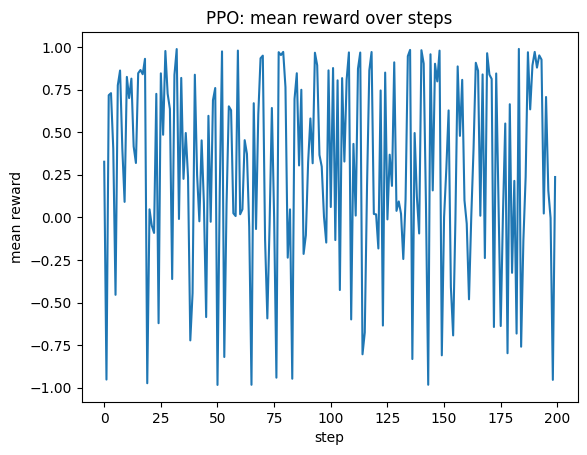

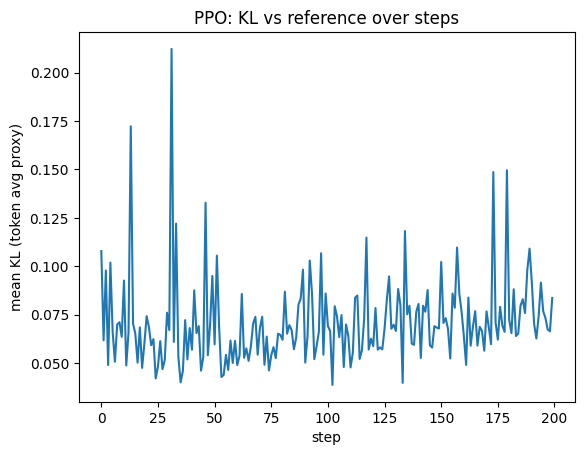

In [14]:
import matplotlib.pyplot as plt

logs_df = pd.read_csv(os.path.join(OUTPUT_DIR, "ppo_logs.csv"))

plt.figure()
plt.plot(logs_df["step"], logs_df["reward_mean"])
plt.xlabel("step")
plt.ylabel("mean reward")
plt.title("PPO: mean reward over steps")
plt.show()

plt.figure()
plt.plot(logs_df["step"], logs_df["kl_mean"])
plt.xlabel("step")
plt.ylabel("mean KL (token avg proxy)")
plt.title("PPO: KL vs reference over steps")
plt.show()

In [15]:
from transformers import AutoModelForCausalLM

trained = AutoModelForCausalLM.from_pretrained(OUTPUT_DIR, torch_dtype=DTYPE).to(DEVICE)
trained.eval()

def gen(model, prompt, max_new_tokens=40):
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=PROMPT_MAX_LEN).to(DEVICE)
    out = model.generate(
        **enc,
        do_sample=True,
        top_k=50,
        temperature=0.9,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id
    )[0]
    return tokenizer.decode(out, skip_special_tokens=True)

test_prompts = [
    "The movie was",
    "I think this film",
    "The acting was",
    "The plot was",
]

for pr in test_prompts:
    out_text = gen(trained, pr, 40)
    comp_only = out_text[len(pr):]
    r = reward_from_text(comp_only)
    print("PROMPT:", pr)
    print("OUTPUT:", out_text[:300])
    print("Completion reward:", r)
    print("="*60)

`torch_dtype` is deprecated! Use `dtype` instead!


PROMPT: The movie was
OUTPUT: The movie was made for a lot of reasons, but I think, at the very least, it is a perfect movie for a first time viewer. The plot is pretty well thought out and the characters are developed in
Completion reward: 0.9864635467529297
PROMPT: I think this film
OUTPUT: I think this film, by the way, is a great movie. I think it's one of the best films I've seen this year. And it's going to go into the awards because it's a great film
Completion reward: 0.9915018081665039
PROMPT: The acting was
OUTPUT: The acting was pretty good. He had some really good lines, especially in the first few minutes of the movie, when he's sitting in the trailer and waiting for that phone call. He did a nice job as
Completion reward: 0.9678659439086914
PROMPT: The plot was
OUTPUT: The plot was, and still is, a very good one. The entire movie is very well done and not too confusing. The story and characters are well thought out and I didn't feel like anything was rushed and
Completion

In [16]:
logs_df

,step,loss,reward_mean,reward_min,reward_max,kl_mean
0,0,0.316092,0.326579,-0.063132,0.716290,0.107783
1,1,0.357532,-0.951956,-0.993576,-0.910336,0.061685
2,2,0.372833,0.716883,0.526850,0.906915,0.097757
3,3,0.490503,0.729044,0.566128,0.891961,0.048904
4,4,0.312987,0.403258,0.305999,0.500517,0.101844
...,...,...,...,...,...,...
195,195,0.110810,0.706610,0.611041,0.802179,0.076774
196,196,0.347616,0.157692,0.126229,0.189155,0.073172
197,197,0.421909,-0.003891,-0.980090,0.972308,0.067296
198,198,0.044475,-0.953770,-0.987031,-0.920510,0.066319


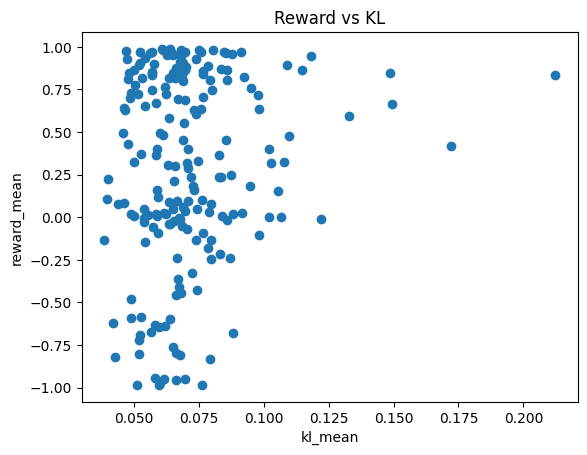

Using columns -> reward: reward_mean | KL: kl_mean
Num points: 200


In [20]:
# pick reward column
reward_col_candidates = ["reward_mean", "reward", "mean_reward"]
reward_col = next((c for c in reward_col_candidates if c in logs_df.columns), None)
if reward_col is None:
    raise ValueError(f"No reward column found. Existing columns: {logs_df.columns.tolist()}")

# pick KL column (prefer your TRUE KL if you logged it)
kl_col_candidates = ["true_kl", "kl_true", "kl_mean_true", "kl_pen", "kl_mean", "kl_raw"]
kl_col = next((c for c in kl_col_candidates if c in logs_df.columns), None)
if kl_col is None:
    raise ValueError(f"No KL column found. Existing columns: {df.columns.tolist()}")

plot_df = logs_df[[reward_col, kl_col]].dropna()

plt.figure()
plt.scatter(plot_df[kl_col].values, plot_df[reward_col].values)
plt.xlabel(kl_col)
plt.ylabel(reward_col)
plt.title("Reward vs KL")
plt.show()

print("Using columns -> reward:", reward_col, "| KL:", kl_col)
print("Num points:", len(plot_df))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.01: win_rate=0.550


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.1: win_rate=0.550


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.2: win_rate=0.725


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.3: win_rate=0.487


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.4: win_rate=0.550


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.5: win_rate=0.600


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.6: win_rate=0.550


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.7: win_rate=0.588


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.8: win_rate=0.650


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=0.9: win_rate=0.525


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

temp=1.0: win_rate=0.600


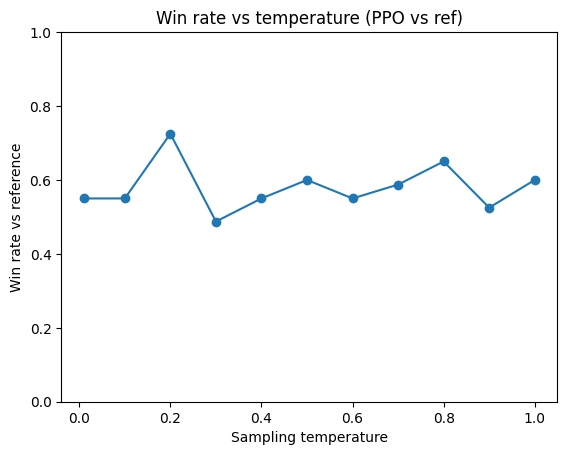

In [21]:
import numpy as np
import torch
from datasets import load_dataset

@torch.no_grad()
def generate_completions(model, prompts, temperature, batch_size=2, max_new_tokens=24, top_k=50):
    model.eval()
    outs = []
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]
        enc = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=PROMPT_MAX_LEN
        ).to(DEVICE)

        gen = model.generate(
            **enc,
            do_sample=True,
            temperature=float(temperature),
            top_k=top_k,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            remove_invalid_values=True,
        )

        # decode completion-only
        for j in range(len(batch)):
            prompt_len = (enc["attention_mask"][j].sum().item())
            comp_ids = gen[j, int(prompt_len):]
            outs.append(tokenizer.decode(comp_ids, skip_special_tokens=True))
    return outs

def rewards_for_texts(texts, batch_size=32):
    # pipeline can take list input; use batching
    scores = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        preds = reward_pipe(chunk)
        for p in preds:
            scores.append(reward_from_text("") if False else (2.0 * pos_prob(p) - 1.0))  # [-1,1]
    return np.array(scores, dtype=np.float32)

@torch.no_grad()
def win_rate_at_temp(policy_model, ref_model, prompts, temperature, n=40, margin=0.05, gen_bs=2):
    # use same prompts, generate 1 completion each model
    prompts = prompts[:n]

    pol_comps = generate_completions(policy_model, prompts, temperature, batch_size=gen_bs, max_new_tokens=MAX_NEW_TOKENS)
    ref_comps = generate_completions(ref_model,   prompts, temperature, batch_size=gen_bs, max_new_tokens=MAX_NEW_TOKENS)

    pol_r = rewards_for_texts(pol_comps)
    ref_r = rewards_for_texts(ref_comps)

    wins = (pol_r > ref_r + margin).sum()
    ties = (np.abs(pol_r - ref_r) <= margin).sum()
    total = len(prompts)
    return (wins + 0.5 * ties) / total

# --- build evaluation prompts (IMDB test split)
ds = load_dataset("imdb")
test_texts = ds["test"]["text"]

def make_prompt(text, n_words=8):
    return " ".join(str(text).split()[:n_words])

eval_prompts = [make_prompt(t, 8) for t in test_texts[:200]]  # pool
np.random.seed(42)
np.random.shuffle(eval_prompts)

temps = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
N_PER_TEMP = 40
MARGIN = 0.05
GEN_BS = 2  # gpt2-large -> keep small

win_rates = []
for t in temps:
    wr = win_rate_at_temp(ac.lm, ref_lm, eval_prompts, t, n=N_PER_TEMP, margin=MARGIN, gen_bs=GEN_BS)
    win_rates.append(wr)
    print(f"temp={t}: win_rate={wr:.3f}")

# plot
plt.figure()
plt.plot(temps, win_rates, marker="o")
plt.xlabel("Sampling temperature")
plt.ylabel("Win rate vs reference")
plt.title("Win rate vs temperature (PPO vs ref)")
plt.ylim(0, 1)
plt.show()
